In [7]:
import torch
import numpy as np
import pandas as pd
import easyocr
from PIL import Image 
import transformers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from transformers import CLIPProcessor, CLIPModel, AutoModelForSeq2SeqLM, AutoTokenizer
from multilingual_clip import pt_multilingual_clip
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available, otherwise fallback to CPU
print(device)

cuda


In [17]:
# Load pre-trained CLIP model and processor
model_name = "M-CLIP/XLM-Roberta-Large-Vit-B-32"
clip_text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(model_name)
clip_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

# model_name = "openai/clip-vit-base-patch32"
# clip_model = CLIPModel.from_pretrained(model_name).eval()
# clip_processor = CLIPProcessor.from_pretrained(model_name)

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
def get_text_features(text):
    """Extracts text features using M-CLIP/XLM-Roberta-Large-Vit-B-32."""
    try:
        text_features = clip_text_model.forward([text], clip_tokenizer)
        return text_features.squeeze().detach().cpu().numpy()  # Convert tensor to numpy array
    except Exception as e:
        print(f"⚠️ Error extracting text features: {e}")
        return None

In [30]:
def get_text_features(text):
    max_tokens = 512
    tokens = clip_tokenizer(text, return_tensors="pt", padding=False, truncation=False).input_ids[0]
    token_chunks = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]

    text_chunks = [clip_tokenizer.decode(chunk, skip_special_tokens=True) for chunk in token_chunks]

    chunk_features = []
    for chunk in text_chunks:
        inputs = clip_tokenizer(text=chunk, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            features = clip_text_model.forward([chunk], clip_tokenizer).squeeze().cpu().numpy()
        chunk_features.append(features)

    final_text_features = np.mean(chunk_features, axis=0) if chunk_features else np.zeros((512,))
    return final_text_features

In [36]:
def get_text_features(text):
    """Extracts text features using M-CLIP/XLM-Roberta-Large-Vit-B-32, handling long texts."""
    try:
        max_tokens = 512  # Maximum tokens per chunk (adjust based on your model's capacity)
        
        # Tokenize the input text
        tokens = clip_tokenizer(text, return_tensors="pt", padding=False, truncation=False).input_ids[0]
        
        # Ensure we don't create empty chunks
        token_chunks = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]
        
        # Check if any chunk is empty (which could happen with very short texts or edge cases)
        if any(len(chunk) == 0 for chunk in token_chunks):
            print("⚠️ Warning: Found empty token chunks!")
            return None  # Early exit if there are empty chunks
        
        # Decode chunks back into text
        text_chunks = [clip_tokenizer.decode(chunk, skip_special_tokens=True) for chunk in token_chunks]
        
        # Process each chunk and extract its features
        chunk_features = []
        for chunk in text_chunks:
            # Tokenize each chunk and get the model features
            inputs = clip_tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                features = clip_text_model.forward([chunk], clip_tokenizer).squeeze().cpu().numpy()
            chunk_features.append(features)
        
        # Average the features from all chunks to get the final representation
        final_text_features = np.mean(chunk_features, axis=0) if chunk_features else np.zeros((512,))
        
        return final_text_features
    except Exception as e:
        print(f"⚠️ Error extracting text features: {e}")
        return None

In [48]:
def get_text_features(text):
    """Extracts text features using M-CLIP/XLM-Roberta-Large-Vit-B-32, handling long texts."""
    try:
        max_tokens = 512  # Maximum tokens per chunk (adjust based on your model's capacity)
        
        # Tokenize the input text with truncation
        tokens = clip_tokenizer(text, return_tensors="pt", padding=False, truncation=True, max_length=512).input_ids[0]
        
        # Ensure we don't create empty chunks
        token_chunks = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]
        
        # Check if any chunk is empty (which could happen with very short texts or edge cases)
        if any(len(chunk) == 0 for chunk in token_chunks):
            print("⚠️ Warning: Found empty token chunks!")
            return None  # Early exit if there are empty chunks
        
        # Decode chunks back into text
        text_chunks = [clip_tokenizer.decode(chunk, skip_special_tokens=True) for chunk in token_chunks]
        
        # Process each chunk and extract its features
        chunk_features = []
        for chunk in text_chunks:
            # Tokenize each chunk and get the model features
            inputs = clip_tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                features = clip_text_model.forward([chunk], clip_tokenizer).squeeze().cpu().numpy()
            chunk_features.append(features)
        
        # Average the features from all chunks to get the final representation
        final_text_features = np.mean(chunk_features, axis=0) if chunk_features else np.zeros((512,))
        
        return final_text_features
    except Exception as e:
        print(f"⚠️ Error extracting text features: {e}")
        return None 

In [10]:
# Initialize EasyOCR reader for OCR
reader = easyocr.Reader(["no", "en"])  # Norwegian and English, because there's some mixing of the languages

def extract_text_easyocr(image_path):
    """Extracts text from an image using EasyOCR."""
    try:
        results = reader.readtext(image_path, detail=0)  # Extract text without coordinates
        return " ".join(results)  # Join extracted words into a single string
    except Exception as e:
        print(f"⚠️ OCR failed for {image_path}: {e}")
        return ""

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\easyocr\detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load

In [11]:
# loading the data
df = pd.read_excel("D:/sample_images_full.xlsx")

In [12]:
# Extract text from images
df["image_path_image_filename_image_1"] = df["image_path_image_filename_image_1"].str.replace(r"^D:/", "E:/", regex=True)

import PIL
PIL.Image.ANTIALIAS = PIL.Image.LANCZOS
df["image_text"] = df["image_path_image_filename_image_1"].apply(extract_text_easyocr)

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
# Merge the extracted text with tweet text
df["combined_text"] = df["tweet"] + " " + df["image_text"]

In [65]:
# Fix the labels, 0=non humor, 1=humor
df["label"] = df["label"].apply(lambda x: 1 if x > 0 else 0)

In [49]:
# Extract CLIP text features for the combined texts
df["text_features"] = df["combined_text"].apply(get_text_features)

In [45]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to extract image features
def get_image_features(image_path):
    """Extracts image embeddings from CLIP."""
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features.cpu().numpy()

In [46]:
# Extract CLIP image features
df["image_features"] = df["image_path_image_filename_image_1"].apply(get_image_features)

# df["image_features"] = df["image_path_image_filename_image_1"].apply(
#     lambda x: get_image_features(x) if pd.notna(x) else None
# )

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [82]:
def combine_features(text_emb, image_emb):
    """
    Combines text and image embeddings into a single vector.

    Parameters:
        text_emb (np.array): Text embedding vector (512-dim).
        image_emb (np.array): Image embedding vector (512-dim).

    Returns:
        np.array: Concatenated feature vector (1024-dim).
    """
    # Ensure embeddings are numpy arrays
    text_emb = np.array(text_emb).flatten()
    image_emb = np.array(image_emb).flatten()

    # Handle missing image embeddings (use zero vector if missing)
    if np.all(image_emb == 0):  
        print("⚠️ Missing image embedding, using only text features.")

    # Concatenate text and image features
    return np.concatenate([text_emb, image_emb])

# Apply the function to all rows
df["combined_features"] = df.apply(lambda row: combine_features(row["text_features"], row["image_features"]), axis=1)

In [87]:
# Verify new class distribution
print(df["label"].value_counts())

label
0    1789
1     388
Name: count, dtype: int64


In [88]:
# Split data before balancing
X_train, X_test, y_train, y_test = train_test_split(df["combined_features"], df["label"], test_size=0.2, random_state=42, stratify=df["label"])

In [89]:
# Convert to NumPy arrays for SMOTE
X_train = np.array(X_train.tolist())  # Convert list of arrays to 2D NumPy array
y_train = np.array(y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print new class distribution
from collections import Counter
print("Resampled class distribution:", Counter(y_train_resampled))

Resampled class distribution: Counter({0: 1431, 1: 1431})


In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the *original, imbalanced* test set
y_pred = clf.predict(np.array(X_test.tolist()))

# Print evaluation metrics
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9134    0.8547    0.8831       358
           1     0.4851    0.6282    0.5475        78

    accuracy                         0.8142       436
   macro avg     0.6993    0.7415    0.7153       436
weighted avg     0.8368    0.8142    0.8231       436



In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the *original, imbalanced* test set
y_pred = clf.predict(np.array(X_test.tolist()))

# Print evaluation metrics
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9134    0.8547    0.8831       358
           1     0.4851    0.6282    0.5475        78

    accuracy                         0.8142       436
   macro avg     0.6993    0.7415    0.7153       436
weighted avg     0.8368    0.8142    0.8231       436



In [92]:
# Looking at the false predictions
df_test = pd.DataFrame({ "tweet": df.loc[X_test.index, "combined_text"], 
                        "image_path": df.loc[X_test.index, "image_path_image_filename_image_1"],
                        "true_label": y_test,
                        "pred_label": y_pred})

# Extract misclassified samples
false_positives = df_test[(df_test["true_label"] == 0) & (df_test["pred_label"] == 1)]
false_negatives = df_test[(df_test["true_label"] == 1) & (df_test["pred_label"] == 0)]

# Display a few misclassified examples
print("\n🔹 False Positives (Non-humor misclassified as humor):")
print(false_positives.head(5))  # Show 5 examples

print("\n🔹 False Negatives (Humor misclassified as non-humor):")
print(false_negatives.head(5))  # Show 5 examples


🔹 False Positives (Non-humor misclassified as humor):
                                                  tweet  \
1999  Kjekt å ta koronatest når alle mine blir rare ...   
985   Altså, jeg skal delta i dette som i så godt so...   
1908  Etter to års pandemi skal USERNAME teste noe i...   
1853  – Hvis pressen la ned i morgen – ville vi da m...   
493   USERNAME USERNAME USERNAME USERNAME Hvis du pr...   

                                        image_path  true_label  pred_label  
1999  E:/Images/Covid/images_1/FM__t2TWQAUJVC6.jpg           0           1  
985   E:/Images/Covid/images_2/EmdQHXyXYAUn3Vu.png           0           1  
1908  E:/Images/Covid/images_1/FIcOgrMXoAYFFnU.png           0           1  
1853  E:/Images/Covid/images_1/FH8ZknGWYAgcZKx.jpg           0           1  
493   E:/Images/Covid/images_2/EWsyLoBU0AI2XYc.png           0           1  

🔹 False Negatives (Humor misclassified as non-humor):
                                                  tweet  \
2147  Hahaha….

C:\Users\sirifris\AppData\Local\Temp\ipykernel_693504\3379348830.py:22: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


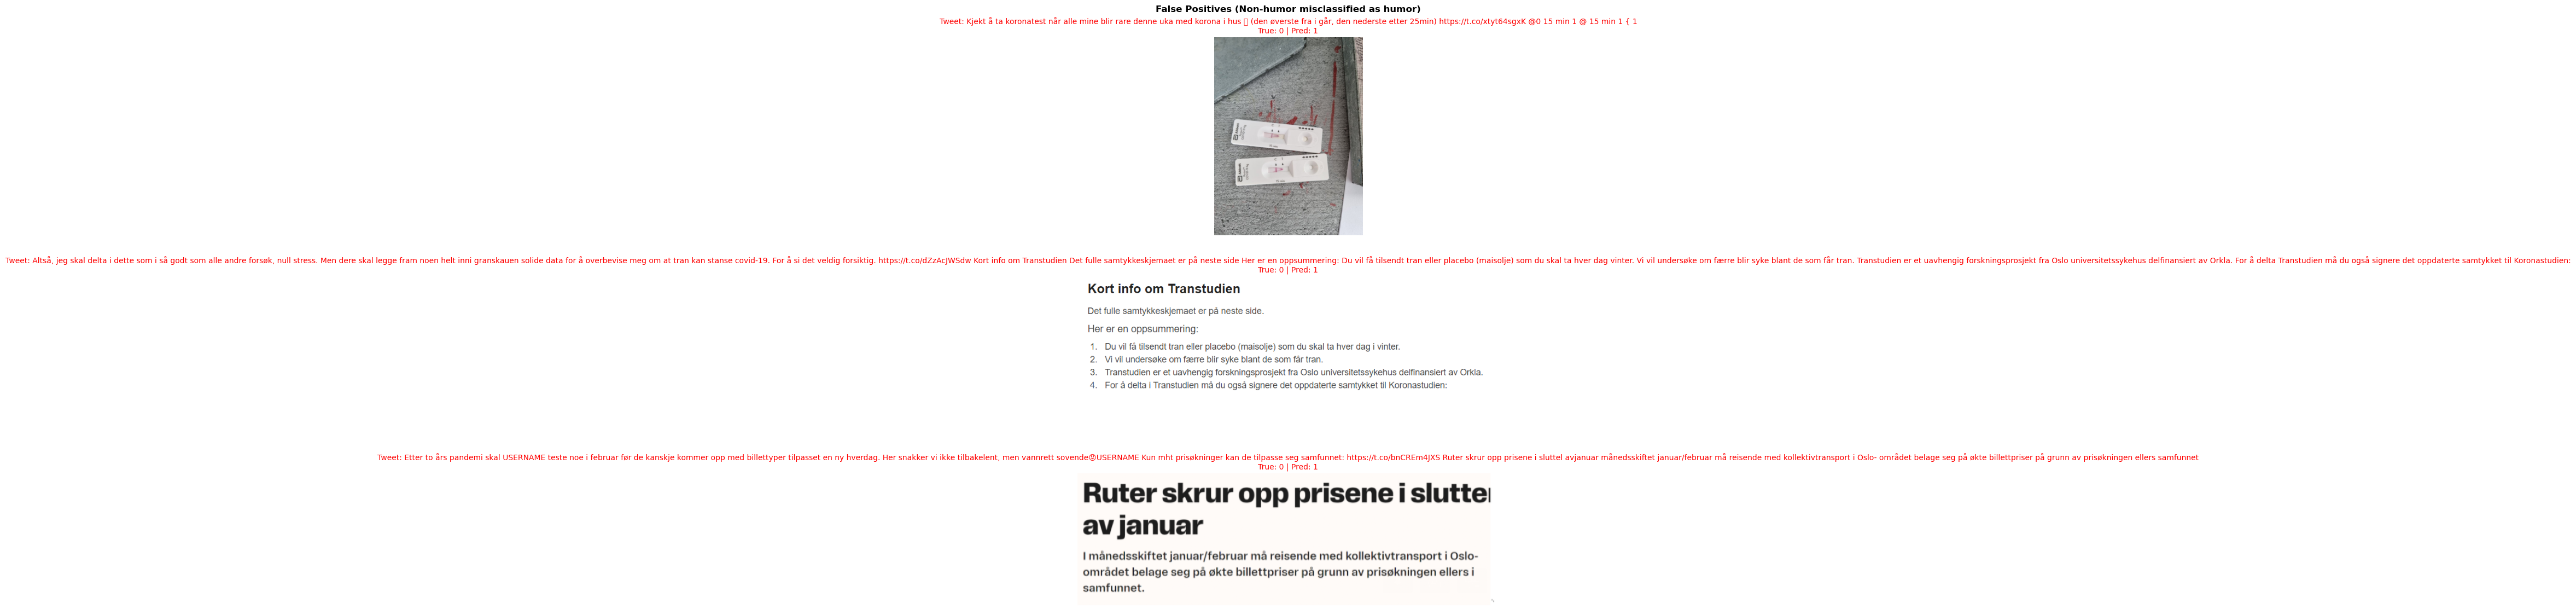

C:\Users\sirifris\AppData\Local\Temp\ipykernel_693504\3379348830.py:22: UserWarning: Glyph 129313 (\N{CLOWN FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129313 (\N{CLOWN FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


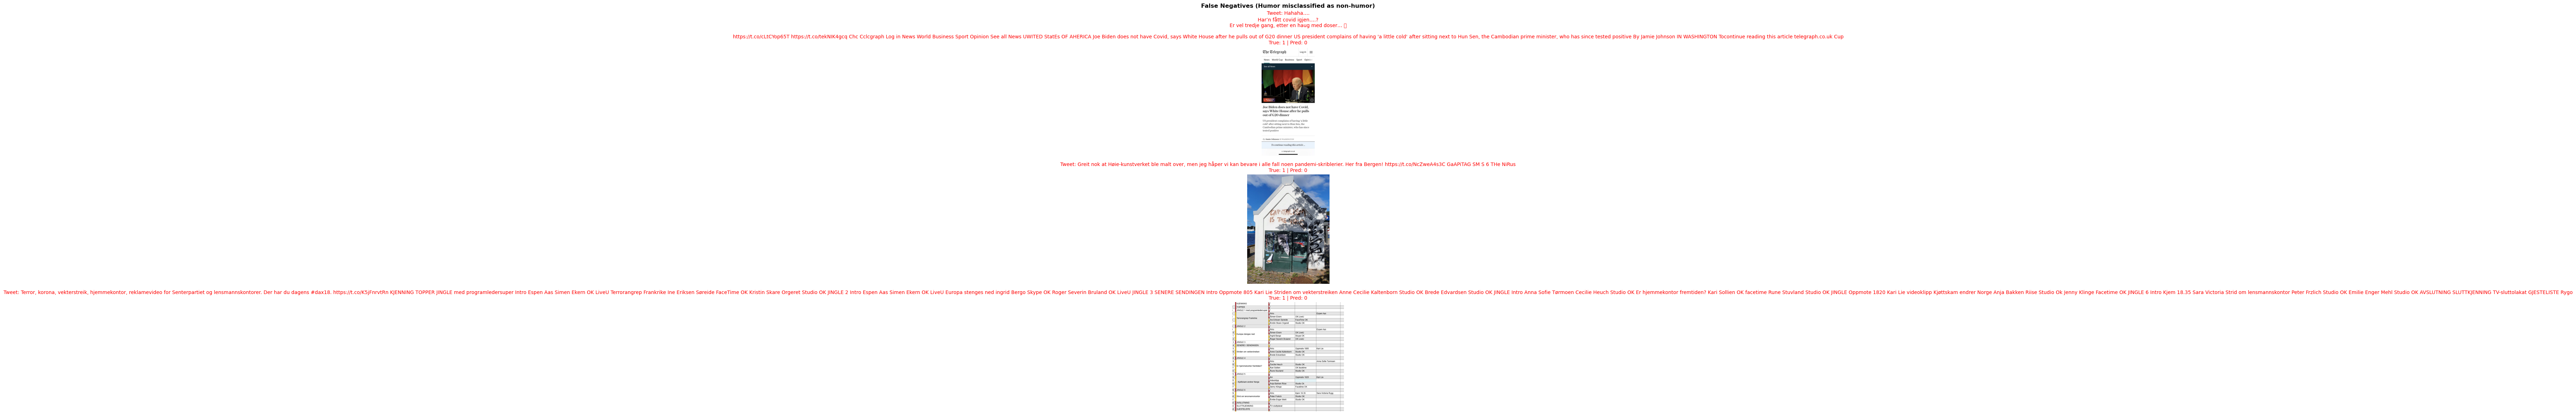

In [93]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_misclassified_samples(df_subset, title):
    """Displays misclassified examples with text and images."""
    fig, axes = plt.subplots(len(df_subset), 1, figsize=(8, len(df_subset) * 4))

    for i, (_, row) in enumerate(df_subset.iterrows()):
        # Load image if available
        img = mpimg.imread(row["image_path"]) if pd.notna(row["image_path"]) else None
        
        # Display image if present
        if img is not None:
            axes[i].imshow(img)
            axes[i].axis("off")

        # Display tweet text and labels
        text_info = f"Tweet: {row['tweet']}\nTrue: {row['true_label']} | Pred: {row['pred_label']}"
        axes[i].set_title(text_info, fontsize=10, color="red" if row['true_label'] != row['pred_label'] else "black")

    plt.suptitle(title, fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Show misclassified examples
show_misclassified_samples(false_positives.head(3), "False Positives (Non-humor misclassified as humor)")
show_misclassified_samples(false_negatives.head(3), "False Negatives (Humor misclassified as non-humor)")